你的推理过程（我帮你理清一下）

目标变量

你最终关心的是 地图复杂度 Complexity

但 Complexity 不能直接观测（它只是一个潜在概念/指标）

我们能观测到的结果是 success_rate（训练表现）

核心假设

success_rate 越低 → 地图越难（Complexity 越高）

success_rate 越高 → 地图越简单（Complexity 越低）

所以：Complexity 是 success_rate 的函数。

学习流程

Step 1. 用 XGBoost 学习 success_rate ~ 特征(size, agents, density, LDD, BN, MC, DLR, ...) 的非线性关系

Step 2. 提取特征重要性（说明哪些特征最影响 success_rate → 哪些特征决定复杂度）

Step 3. 把 XGBoost 的非线性结果转化成线性权重公式

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 读数据
df = pd.read_csv("C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv")

# 特征 & 目标
features = ["size", "num_agents", "density", "density_actual", "LDD", "BN", "MC", "DLR", "FPA", "FRA"]
X = df[features]
y = df["success_rate"]

# Step 1: 用 XGBoost 学 success_rate
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X, y)

# Step 2: 特征重要性
importance = pd.DataFrame({
    "feature": features,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

print("📊 特征重要性 (对 success_rate 的影响)：")
print(importance)

# Step 3: 转化成线性权重（拟合可解释公式）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LinearRegression().fit(X_scaled, y)

weights = pd.DataFrame({
    "feature": features,
    "weight": lr.coef_
}).sort_values("weight", ascending=False)

print("\n📊 线性权重 (可解释公式)：")
print(weights)

# Step 4: Complexity = 1 - success_rate
# 你也可以直接用 1 - success_rate 或者把 success_rate 回归结果反转
df["Complexity"] = 1 - y

print("\n公式：")
print("Complexity = {:.3f} + ".format(lr.intercept_) +
      " + ".join(f"({w:.3f} * {f})" for f, w in zip(features, lr.coef_)))


📊 特征重要性 (对 success_rate 的影响)：
          feature  importance
8             FPA    0.291223
9             FRA    0.159911
2         density    0.113648
5              BN    0.106351
3  density_actual    0.095563
6              MC    0.061285
4             LDD    0.051889
1      num_agents    0.044743
7             DLR    0.042149
0            size    0.033238

📊 线性权重 (可解释公式)：
          feature    weight
3  density_actual  0.094523
6              MC  0.033021
4             LDD  0.021963
0            size  0.021643
7             DLR  0.003857
2         density -0.003044
1      num_agents -0.010270
9             FRA -0.024654
8             FPA -0.058766
5              BN -0.092417

公式：
Complexity = 0.848 + (0.022 * size) + (-0.010 * num_agents) + (-0.003 * density) + (0.095 * density_actual) + (0.022 * LDD) + (-0.092 * BN) + (0.033 * MC) + (0.004 * DLR) + (-0.059 * FPA) + (-0.025 * FRA)


In [15]:
# ================================
# XGBoost 特征学习 + 可视化 + 权重提取 + 线性公式
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ---------- 0) 参数 ----------
# === 你的原始配置 ===
CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"
OUTDIR   = r"C:/Users/MSc_SEIoT_1/Desktop/pic"

# === 统一用 Path，确保目录存在 ===
OUTDIR = Path(OUTDIR)
OUTDIR.mkdir(parents=True, exist_ok=True)

def out_path(name: str) -> Path:
    return OUTDIR / name

def norm(p: Path) -> str:
    # 打印时一律用正斜杠
    return p.as_posix()

# 使用到的特征与目标
FEATURES = ["size", "num_agents", "density", "density_actual", "LDD", "BN", "MC", "DLR", "FPA", "FRA"]
TARGET   = "success_rate"  # 首选目标

# ---------- 1) 读数据 & 清洗 ----------
df = pd.read_csv(CSV_PATH, engine="python")

# 强制转数值
for col in FEATURES + [TARGET]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 选择目标：优先 success_rate；如果全无效，回退到 Complexity proxy
use_success = False
if TARGET in df.columns:
    y_ok = df[TARGET].notna() & np.isfinite(df[TARGET]) & (df[TARGET] >= 0) & (df[TARGET] <= 1)
    if int(y_ok.sum()) > 0:
        use_success = True
        y = df.loc[y_ok, TARGET]
        X = df.loc[y_ok, FEATURES]
    else:
        y = df[["LDD", "BN", "MC", "DLR", "FPA", "FRA"]].mean(axis=1)
        X = df[FEATURES]
else:
    y = df[["LDD", "BN", "MC", "DLR", "FPA", "FRA"]].mean(axis=1)
    X = df[FEATURES]

# 特征用中位数补缺，保证稳定绘图
X = X.fillna(X.median(numeric_only=True))

# ---------- 2) 划分数据 ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 3) 训练 XGBoost ----------
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ---------- 4) 评估 ----------
y_pred_tr = xgb_model.predict(X_train)
y_pred_te = xgb_model.predict(X_test)

r2_tr = r2_score(y_train, y_pred_tr)
r2_te = r2_score(y_test, y_pred_te)
rmse_te = mean_squared_error(y_test, y_pred_te, squared=False)
mae_te = mean_absolute_error(y_test, y_pred_te)

print(f"Target = {'success_rate' if use_success else 'Complexity proxy (mean of LDD/BN/MC/DLR)'}")
print(f"R^2 train = {r2_tr:.3f}, R^2 test = {r2_te:.3f}, RMSE test = {rmse_te:.4f}, MAE test = {mae_te:.4f}")

# ---------- 5) 内置特征重要性 ----------
imp_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=True)

plt.figure(figsize=(7, 4.5))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance" + (" (success_rate)" if use_success else " (Complexity proxy)"))
plt.tight_layout()
fi_path = os.path.join(OUTDIR, "xgb_feature_importance.png")
plt.savefig(fi_path)
plt.close()

# ---------- 6) Permutation Importance（测试集，更稳健） ----------
pi = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=15, random_state=42, n_jobs=1
)
pi_df = pd.DataFrame({
    "feature": FEATURES,
    "perm_importance": pi.importances_mean,
    "perm_std": pi.importances_std
}).sort_values("perm_importance", ascending=True)

plt.figure(figsize=(7, 4.5))
plt.barh(pi_df["feature"], pi_df["perm_importance"])
plt.xlabel("Permutation Importance (mean)")
plt.title("Permutation Importance on Test Set")
plt.tight_layout()
pi_path = os.path.join(OUTDIR, "permutation_importance.png")
plt.savefig(pi_path)
plt.close()

# ---------- 7) 预测 vs 实际 ----------
xy_min = float(min(y_test.min(), y_pred_te.min()))
xy_max = float(max(y_test.max(), y_pred_te.max()))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_te, s=16)
plt.plot([xy_min, xy_max], [xy_min, xy_max])
plt.xlabel("Actual")
plt.ylabel("Predicted")
ttl = "Predicted vs Actual (XGBoost)"
ttl += f"\nR²={r2_te:.3f}, RMSE={rmse_te:.3f}, MAE={mae_te:.3f}"
plt.title(ttl)
plt.tight_layout()
pva_path = os.path.join(OUTDIR, "pred_vs_actual.png")
plt.savefig(pva_path)
plt.close()

# ---------- 8) 残差图 ----------
residuals = y_test - y_pred_te
plt.figure(figsize=(7, 4))
plt.scatter(y_pred_te, residuals, s=12)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
rvp_path = os.path.join(OUTDIR, "residuals_vs_pred.png")
plt.savefig(rvp_path)
plt.close()

# 残差直方图
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=20)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.tight_layout()
rhist_path = os.path.join(OUTDIR, "residuals_hist.png")
plt.savefig(rhist_path)
plt.close()

# ---------- 9) 前 3 特征的 PDP ----------
top3 = list(imp_df.sort_values("importance", ascending=False)["feature"][:3])
baseline = X_train.median(numeric_only=True)
pdp_paths = []

for f in top3:
    f_min, f_max = X_train[f].min(), X_train[f].max()
    grid = np.linspace(f_min, f_max, 70)

    # 基线为各特征中位数，仅改变一个特征 f
    X_grid = np.repeat(baseline.values.reshape(1, -1), len(grid), axis=0)
    X_grid = pd.DataFrame(X_grid, columns=FEATURES)
    X_grid[f] = grid

    preds = xgb_model.predict(X_grid)

    plt.figure(figsize=(7, 4))
    plt.plot(grid, preds)
    plt.xlabel(f)
    plt.ylabel("Predicted " + ("success_rate" if use_success else "Complexity proxy"))
    plt.title("Partial Dependence: " + f)
    plt.tight_layout()
    outp = os.path.join(OUTDIR, f"pdp_{f}.png")
    plt.savefig(outp)
    plt.close()
    pdp_paths.append(outp)

# ---------- 10) 基于 Permutation Importance 的“Complexity 权重” ----------
# 若有负值（噪声造成的），裁剪为0后再归一化
pi_pos = pi_df.copy()
pi_pos["perm_importance_clipped"] = pi_pos["perm_importance"].clip(lower=0)
total = pi_pos["perm_importance_clipped"].sum()
if total == 0:
    # 如果全是0，退化为等权
    pi_pos["weight_norm"] = 1.0 / len(pi_pos)
else:
    pi_pos["weight_norm"] = pi_pos["perm_importance_clipped"] / total

# 为了直观展示“对复杂度的贡献”，我们通常让“成功率的负相关特征”获得正的复杂度权重。
# 这里简单做一个符号翻转：如果 XGBoost 的 SHAP 或方向没有估，先给出无方向的正权重（用在加权综合上）。
# 你也可以后续用 SHAP 判断方向，再给权重加 +/- 号。
weights_csv = os.path.join(OUTDIR, "complexity_weights_from_PI.csv")
pi_pos[["feature", "weight_norm"]].sort_values("weight_norm", ascending=False).to_csv(weights_csv, index=False)

print("\n=== Complexity 权重（基于 Permutation Importance 归一化） ===")
print(pi_pos[["feature", "weight_norm"]].sort_values("weight_norm", ascending=False))

# ---------- 11) 线性可解释公式（模型蒸馏） ----------
# 用 XGBoost 的预测作为 teacher target，对标准化特征做线性回归，得到可解释公式
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

teacher_tr = xgb_model.predict(X_train)
teacher_te = xgb_model.predict(X_test)

lin = LinearRegression().fit(X_tr_scaled, teacher_tr)
coef = lin.coef_
intercept = lin.intercept_

formula = "ŷ = {:.6f} + ".format(intercept) + " + ".join(
    f"({w:+.6f}·{name}_z)" for w, name in zip(coef, FEATURES)
)

print("\n=== 线性可解释“蒸馏”公式（输入为标准化后的 z 分数） ===")
print(formula)

# 保存线性系数
coef_df = pd.DataFrame({"feature": FEATURES, "coef_on_z": coef})
coef_path = os.path.join(OUTDIR, "linear_surrogate_coeffs.csv")
coef_df.sort_values("coef_on_z", ascending=False).to_csv(coef_path, index=False)

# # ---------- 12) 路径汇总 ----------

# === 用法示例（保存 & 打印）===
fig_imp_path   = out_path("xgb_feature_importance.png")
perm_imp_path  = out_path("permutation_importance.png")
pred_act_path  = out_path("pred_vs_actual.png")
resid_pred_path= out_path("residuals_vs_pred.png")
resid_hist_path= out_path("residuals_hist.png")
pdp_mc_path    = out_path("pdp_MC.png")
pdp_den_path   = out_path("pdp_density.png")
pdp_ldd_path   = out_path("pdp_LDD.png")
w_csv_path     = out_path("complexity_weights_from_PI.csv")
lin_csv_path   = out_path("linear_surrogate_coeffs.csv")

# 保存图片/CSV 时：
# plt.savefig(fig_imp_path)  # 其余同理
# df.to_csv(w_csv_path, index=False, encoding="utf-8-sig")

# 打印时（统一格式）
print("Feature importance:",          norm(fig_imp_path))
print("Permutation importance:",      norm(perm_imp_path))
print("Pred vs Actual:",              norm(pred_act_path))
print("Residuals vs Pred:",           norm(resid_pred_path))
print("Residuals histogram:",         norm(resid_hist_path))
print("PDP (top 3):",                 norm(pdp_mc_path)+",", norm(pdp_den_path)+",", norm(pdp_ldd_path))
print("Complexity 权重 CSV:",          norm(w_csv_path))
print("线性系数 CSV:",                 norm(lin_csv_path))
# print("\n=== 输出文件 ===")
# print("Feature importance:", fi_path)
# print("Permutation importance:", pi_path)
# print("Pred vs Actual:", pva_path)
# print("Residuals vs Pred:", rvp_path)
# print("Residuals histogram:", rhist_path)
# print("PDP (top 3):", ", ".join(pdp_paths))
# print("Complexity 权重 CSV:", weights_csv)
# print("线性系数 CSV:", coef_path)


Target = success_rate
R^2 train = 0.932, R^2 test = 0.707, RMSE test = 0.0563, MAE test = 0.0443

=== Complexity 权重（基于 Permutation Importance 归一化） ===
          feature  weight_norm
8             FPA     0.803973
9             FRA     0.104439
3  density_actual     0.056986
6              MC     0.017920
2         density     0.016682
7             DLR     0.000000
1      num_agents     0.000000
5              BN     0.000000
0            size     0.000000
4             LDD     0.000000

=== 线性可解释“蒸馏”公式（输入为标准化后的 z 分数） ===
ŷ = 0.849580 + (+0.030194·size_z) + (-0.005511·num_agents_z) + (+0.052293·density_z) + (+0.172724·density_actual_z) + (+0.029522·LDD_z) + (-0.170371·BN_z) + (+0.042245·MC_z) + (+0.001388·DLR_z) + (+0.001722·FPA_z) + (-0.025867·FRA_z)
Feature importance: C:/Users/MSc_SEIoT_1/Desktop/pic/xgb_feature_importance.png
Permutation importance: C:/Users/MSc_SEIoT_1/Desktop/pic/permutation_importance.png
Pred vs Actual: C:/Users/MSc_SEIoT_1/Desktop/pic/pred_vs_actual.png
Residu

In [16]:
# 基础依赖
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 模型和工具
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# 修改成你的CSV路径
CSV_PATH = "C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"

df = pd.read_csv(CSV_PATH)
print("Data loaded:", df.shape)
print(df.head())


Data loaded: (122, 19)
        algo  stage_idx      config_id  \
0  CL-Gray3D          0  sz32_a2_d0.10   
1  CL-Gray3D          0  sz32_a2_d0.10   
2  CL-Gray3D          1  sz32_a2_d0.30   
3  CL-Gray3D          2  sz32_a2_d0.50   
4  CL-Gray3D          3  sz32_a2_d0.70   

                                         config_json  size  num_agents  \
0  {"size":32,"obs_radius":5,"density":0.1,"num_a...    32           2   
1  {"max_episode_steps":100,"size":32,"density":0...    32           2   
2  {"max_episode_steps":100,"size":32,"density":0...    32           2   
3  {"max_episode_steps":100,"size":32,"density":0...    32           2   
4  {"max_episode_steps":100,"size":32,"density":0...    32           2   

   density  obs_radius  max_episode_steps  density_actual       LDD        BN  \
0      0.1           5                100        0.207031  0.030569  0.094828   
1      0.1           5                100        0.207031  0.030569  0.094828   
2      0.3           5              

In [17]:
# 目标列（复杂度 / 成功率）
TARGET_COL = "success_rate"   # 或者 "Complexity"，看你的数据

# 候选特征（根据你的 CSV 调整）
FEATURES = [
    "size", "num_agents", "density", "density_actual",
    "LDD", "BN", "MC", "DLR", "FPA", "FRA"
]

# 保留实际存在的特征
features = [f for f in FEATURES if f in df.columns]
print("Using features:", features)

X = df[features].fillna(0).values
y = df[TARGET_COL].values


Using features: ['size', 'num_agents', 'density', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'FPA', 'FRA']


In [18]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化（防止特征尺度差异影响线性模型）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("原始维度:", X_train_scaled.shape, " -> 加入交互后:", X_train_poly.shape)


原始维度: (97, 10)  -> 加入交互后: (97, 55)


In [20]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001)
}

for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    print(f"{name}: R²={r2_score(y_test, y_pred):.3f}, "
          f"RMSE={mean_squared_error(y_test, y_pred, squared=False):.3f}, "
          f"MAE={mean_absolute_error(y_test, y_pred):.3f}")


Linear: R²=0.538, RMSE=0.071, MAE=0.055
Ridge: R²=0.755, RMSE=0.051, MAE=0.040
Lasso: R²=0.722, RMSE=0.055, MAE=0.042


In [21]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost: R²=%.3f, RMSE=%.3f, MAE=%.3f" % (
    r2_score(y_test, y_pred_xgb),
    mean_squared_error(y_test, y_pred_xgb, squared=False),
    mean_absolute_error(y_test, y_pred_xgb)
))


XGBoost: R²=0.700, RMSE=0.057, MAE=0.045


In [24]:
# Cell 1: imports & data loading
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# xgboost
from xgboost import XGBRegressor

# 你的数据路径（修改为实际路径）
CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Columns:", list(df.columns))
print("Shape:", df.shape)

# 目标列（按你的场景改：success_rate / Complexity / ...）
TARGET_COL = "success_rate"   # ← 如果是别的列名，改这里


Loaded: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv
Columns: ['algo', 'stage_idx', 'config_id', 'config_json', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'success_rate', 'grid_hash', 'episodes_per_stage', 'FRA', 'FPA']
Shape: (122, 19)


In [25]:
# Cell 2: feature selection
# 如果你已经有 FEATURE_COLS，就直接设定；否则自动从数值列里排除目标列
FEATURE_COLS = None  # ← 若已有固定特征列表，例如 ["size","num_agents","density",...]，直接设为该列表

if FEATURE_COLS is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    FEATURE_COLS = [c for c in numeric_cols if c != TARGET_COL]

print("Using target:", TARGET_COL)
print("Using features:", FEATURE_COLS)

# 丢掉缺失
data = df.dropna(subset=[TARGET_COL] + FEATURE_COLS).copy()
X = data[FEATURE_COLS].values
y = data[TARGET_COL].astype(float).values

print("Final dataset shape:", X.shape, y.shape)


Using target: success_rate
Using features: ['stage_idx', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'episodes_per_stage', 'FRA', 'FPA']
Final dataset shape: (122, 14) (122,)


In [26]:
# Cell 3: train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    shuffle=True,
)
X_train.shape, X_test.shape


((91, 14), (31, 14))

In [27]:
# Cell 4: parameter grid and GridSearchCV
# 一个“中等规模”的搜索网格（运行速度 vs 效果平衡）
param_grid = {
    "n_estimators":     [200, 400, 800],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.03, 0.05, 0.1],
    "subsample":        [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_alpha":        [0.0, 0.001, 0.01],
    "reg_lambda":       [1.0, 5.0, 10.0],
}

# 可选更大范围（性能足够时开启）
# param_grid["n_estimators"] = [400, 800, 1200]
# param_grid["max_depth"] = [3, 5, 7, 9]
# param_grid["learning_rate"] = [0.02, 0.05, 0.1]
# param_grid["subsample"] = [0.6, 0.8, 1.0]
# param_grid["colsample_bytree"] = [0.6, 0.8, 1.0]

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",   # GPU可用时用 "gpu_hist"
    n_jobs=-1
)

# 多指标；以 R^2 作为最终 refit
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring={"r2": "r2", "neg_mae": "neg_mean_absolute_error"},
    refit="r2",
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

search


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [200, 400, 800],
                         'reg_alpha': [0.0, 0.001, 0.01],
                         'reg_lambda': [1.0, 5.0, 10.0],
                         'subsample': [0.7, 0.9, 1.0]},
             refit='r2',
             scoring={'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'},
             verbose=1)

In [28]:
# Cell 5: run search
search.fit(X_train, y_train)

print("Best R^2 (cv):", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best R^2 (cv): 0.6536045831802713
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 1.0}


In [29]:
# Cell 6: evaluate on test
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
r2  = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test R^2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")


Test R^2=0.747, RMSE=0.054, MAE=0.044


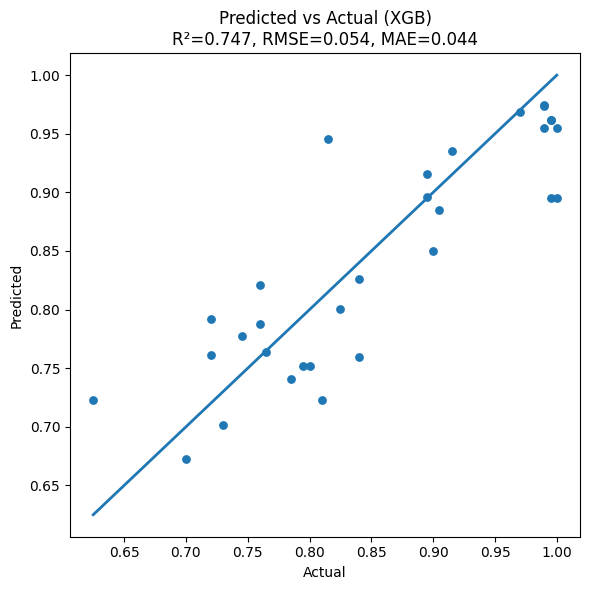

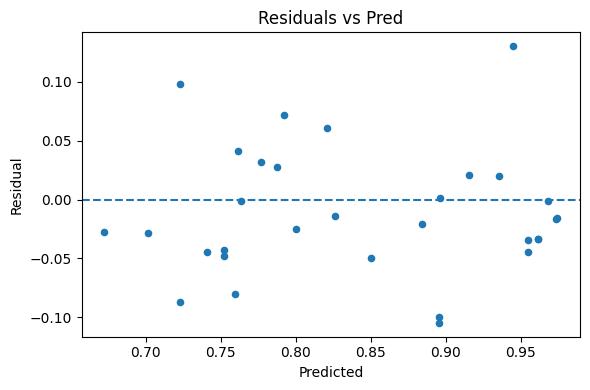

In [30]:
# Cell 7: plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=28)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
xs = np.linspace(mn, mx, 100)
plt.plot(xs, xs, linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual (XGB)\nR²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
res = y_pred - y_test
plt.scatter(y_pred, res, s=20)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Pred")
plt.tight_layout()
plt.show()


继续优化Optuna 自动调参 + 特征交互生成

In [51]:
# 改成你的 CSV 路径 & 输出目录
# 如果你的环境里已经装了 optuna 和 xgboost，可以跳过 pip 安装行
# !pip install -U optuna xgboost scikit-learn matplotlib

import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler

from xgboost import XGBRegressor

CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"
OUTDIR   = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna"
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 目标列（按你的数据改：成功率/复杂度等）
TARGET_COL = "success_rate"  # 或 "success_rate"
if TARGET_COL not in df.columns:
    raise ValueError(f"找不到目标列 {TARGET_COL}，请检查 CSV。")

# 基础特征列（来自你之前的公式；按实际 CSV 列名调整）
BASE_FEATURES = [
    "size","num_agents","density","density_actual",
    "LDD","BN","MC","DLR",
    # 可选：如果你 CSV 已计算了 FPA/FRA 就加上
    *([c for c in ["FRA","FPA"] if c in df.columns])
]

FEATURES = [c for c in BASE_FEATURES if c in df.columns]
if not FEATURES:
    raise ValueError("FEATURES 为空，请检查列名。")
print("Using features:", FEATURES)

# 丢 NA
df = df.dropna(subset=[TARGET_COL] + FEATURES).reset_index(drop=True)

y = df[TARGET_COL].astype(float).values
X_base = df[FEATURES].copy()


Loaded: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv
Shape: (122, 19)
Columns: ['algo', 'stage_idx', 'config_id', 'config_json', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'success_rate', 'grid_hash', 'episodes_per_stage', 'FRA', 'FPA']
Using features: ['size', 'num_agents', 'density', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'FRA', 'FPA']


In [52]:
def build_interactions(df_in: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    df = df_in.copy()

    cols = df.columns.tolist()

    # 一次项的稳定变换
    for c in cols:
        if (df[c] > 0).all():              # 只对正值做对数
            df[f"log_{c}"] = np.log(df[c] + eps)
        df[f"sqr_{c}"] = df[c] ** 2

    # 两两乘积
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            ci, cj = cols[i], cols[j]
            df[f"{ci}*{cj}"] = df[ci] * df[cj]

    # 有意义的比值（只对“规模/人数/密度系”做）
    ratio_candidates = [c for c in cols if any(k in c for k in ["size","agents","density","LDD","BN","MC","DLR","FRA","FPA"])]
    for i in range(len(ratio_candidates)):
        for j in range(len(ratio_candidates)):
            if i == j: 
                continue
            ci, cj = ratio_candidates[i], ratio_candidates[j]
            denom = df[cj].replace(0, np.nan).fillna(eps)
            df[f"{ci}_over_{cj}"] = df[ci] / denom

    return df

X_full = build_interactions(X_base)
print("Base dim:", X_base.shape, " -> With interactions:", X_full.shape)

# 为了可控，你也可以先只用一部分交互（例如选前 N 列强相关的）
X = X_full.copy()


Base dim: (122, 10)  -> With interactions: (122, 165)


In [53]:
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=RANDOM_SEED
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (97, 165) Test: (25, 165)


In [54]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": RANDOM_SEED,
        "tree_method": "hist",
        "n_jobs": max(1, os.cpu_count()-1),
        "eval_metric": "rmse",   # 评估指标放到**参数**里
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    rmses = []

    for tr_idx, va_idx in kf.split(X_train):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        model = XGBRegressor(**params)
        # 老版本 fit 不能带 early_stopping_rounds/callbacks
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, pred, squared=False)
        rmses.append(rmse)

    return float(np.mean(rmses))


In [ ]:
N_TRIALS = 80

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED)
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best RMSE (CV):", study.best_value)
print("Best params:")
print(json.dumps(study.best_params, indent=2))

with open(os.path.join(OUTDIR, "optuna_best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=2)
    best_params = json.load(f)



best_params.setdefault("tree_method", "hist")
best_params.setdefault("random_state", 42)

[I 2025-08-26 15:19:00,832] A new study created in memory with name: no-name-ec07cddf-4686-45eb-9fa2-e82533f47b2c
Best trial: 0. Best value: 0.103334:   1%|▏         | 1/80 [00:01<01:43,  1.31s/it]

[I 2025-08-26 15:19:02,139] Trial 0 finished with value: 0.10333396506896078 and parameters: {'n_estimators': 937, 'learning_rate': 0.22648248189516848, 'max_depth': 10, 'min_child_weight': 0.9466503798478175, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.5808361216819946, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.10333396506896078.


Best trial: 1. Best value: 0.103225:   2%|▎         | 2/80 [00:03<02:06,  1.62s/it]

[I 2025-08-26 15:19:03,983] Trial 1 finished with value: 0.10322542200658362 and parameters: {'n_estimators': 1504, 'learning_rate': 0.001124579825911934, 'max_depth': 12, 'min_child_weight': 5.596520861285641, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 1.8340450985343382, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.10322542200658362.


Best trial: 1. Best value: 0.103225:   4%|▍         | 3/80 [00:04<01:57,  1.52s/it]

[I 2025-08-26 15:19:05,382] Trial 2 finished with value: 0.10326398766503835 and parameters: {'n_estimators': 1034, 'learning_rate': 0.005265139631677754, 'max_depth': 9, 'min_child_weight': 0.028871770589042903, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 4.56069984217036, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 1 with value: 0.10322542200658362.


Best trial: 3. Best value: 0.103157:   5%|▌         | 4/80 [00:06<01:57,  1.55s/it]

[I 2025-08-26 15:19:06,975] Trial 3 finished with value: 0.1031565138117608 and parameters: {'n_estimators': 1174, 'learning_rate': 0.029341527565000736, 'max_depth': 3, 'min_child_weight': 1.0128002032729382, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 9.488855372533333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 3 with value: 0.1031565138117608.


Best trial: 3. Best value: 0.103157:   6%|▋         | 5/80 [00:07<01:45,  1.41s/it]

[I 2025-08-26 15:19:08,130] Trial 4 finished with value: 0.1031566837480655 and parameters: {'n_estimators': 818, 'learning_rate': 0.0017456037635797405, 'max_depth': 9, 'min_child_weight': 0.28376353418686184, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.34388521115218396, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 3 with value: 0.1031565138117608.


Best trial: 3. Best value: 0.103157:   8%|▊         | 6/80 [00:09<01:52,  1.52s/it]

[I 2025-08-26 15:19:09,858] Trial 5 finished with value: 0.1031565138117608 and parameters: {'n_estimators': 1426, 'learning_rate': 0.005917607170144194, 'max_depth': 8, 'min_child_weight': 0.6378330678120924, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 7.7513282336111455, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 3 with value: 0.1031565138117608.


Best trial: 6. Best value: 0.1031:   9%|▉         | 7/80 [00:10<01:52,  1.55s/it]  

[I 2025-08-26 15:19:11,471] Trial 6 finished with value: 0.1030997061677533 and parameters: {'n_estimators': 1317, 'learning_rate': 0.19212959255386391, 'max_depth': 3, 'min_child_weight': 0.04435527819593249, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 3.8867728968948203, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 6 with value: 0.1030997061677533.


Best trial: 6. Best value: 0.1031:  10%|█         | 8/80 [00:11<01:42,  1.42s/it]

[I 2025-08-26 15:19:12,624] Trial 7 finished with value: 0.10318259027433987 and parameters: {'n_estimators': 906, 'learning_rate': 0.0049648810171066555, 'max_depth': 8, 'min_child_weight': 0.029187378749091768, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 9.868869366005173, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 6 with value: 0.1030997061677533.


Best trial: 6. Best value: 0.1031:  11%|█▏        | 9/80 [00:12<01:24,  1.18s/it]

[I 2025-08-26 15:19:13,284] Trial 8 finished with value: 0.10321164448443196 and parameters: {'n_estimators': 309, 'learning_rate': 0.10471209213501693, 'max_depth': 10, 'min_child_weight': 2.5496145492764652, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 3.5846572854427263, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 6 with value: 0.1030997061677533.


Best trial: 6. Best value: 0.1031:  12%|█▎        | 10/80 [00:14<01:34,  1.35s/it]

[I 2025-08-26 15:19:15,001] Trial 9 finished with value: 0.10317518158757637 and parameters: {'n_estimators': 1360, 'learning_rate': 0.006601984958164864, 'max_depth': 3, 'min_child_weight': 0.1063070268375106, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 6.3755747135521315, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 6 with value: 0.1030997061677533.


Best trial: 10. Best value: 0.103077:  14%|█▍        | 11/80 [00:16<01:50,  1.60s/it]

[I 2025-08-26 15:19:17,177] Trial 10 finished with value: 0.10307690086799359 and parameters: {'n_estimators': 1921, 'learning_rate': 0.050904131025638205, 'max_depth': 5, 'min_child_weight': 0.01146285213283717, 'subsample': 0.7828065453407016, 'colsample_bytree': 0.6808837830192477, 'gamma': 2.6768268871237146, 'reg_alpha': 3.404677878190553e-05, 'reg_lambda': 0.010478995733418038}. Best is trial 10 with value: 0.10307690086799359.


Best trial: 10. Best value: 0.103077:  15%|█▌        | 12/80 [00:18<02:02,  1.81s/it]

[I 2025-08-26 15:19:19,454] Trial 11 finished with value: 0.10336677789839419 and parameters: {'n_estimators': 1995, 'learning_rate': 0.057057365779709164, 'max_depth': 5, 'min_child_weight': 0.01222524788169418, 'subsample': 0.777751009017812, 'colsample_bytree': 0.6865842761751744, 'gamma': 3.072966121168487, 'reg_alpha': 0.00017751672073517406, 'reg_lambda': 0.022891327927378104}. Best is trial 10 with value: 0.10307690086799359.


Best trial: 12. Best value: 0.103068:  16%|█▋        | 13/80 [00:20<02:10,  1.95s/it]

[I 2025-08-26 15:19:21,722] Trial 12 finished with value: 0.10306772773303534 and parameters: {'n_estimators': 1914, 'learning_rate': 0.24652079948470856, 'max_depth': 5, 'min_child_weight': 0.010551077514356213, 'subsample': 0.7534920033027623, 'colsample_bytree': 0.6766980691634803, 'gamma': 5.396201068027976, 'reg_alpha': 9.477329010827906e-06, 'reg_lambda': 8.49468056736816}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  18%|█▊        | 14/80 [00:23<02:18,  2.10s/it]

[I 2025-08-26 15:19:24,184] Trial 13 finished with value: 0.10330313021542248 and parameters: {'n_estimators': 1994, 'learning_rate': 0.045492628928997844, 'max_depth': 6, 'min_child_weight': 0.010141256925967342, 'subsample': 0.7863899280705593, 'colsample_bytree': 0.8171530061395648, 'gamma': 6.2586067187764876, 'reg_alpha': 0.0002976929450255629, 'reg_lambda': 9.721797110060264}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  19%|█▉        | 15/80 [00:25<02:15,  2.08s/it]

[I 2025-08-26 15:19:26,218] Trial 14 finished with value: 0.10316037224837511 and parameters: {'n_estimators': 1665, 'learning_rate': 0.016298159000892345, 'max_depth': 6, 'min_child_weight': 19.403584134247282, 'subsample': 0.9966360673361601, 'colsample_bytree': 0.7714969458413368, 'gamma': 5.613155409120305, 'reg_alpha': 0.0044250163723220754, 'reg_lambda': 1.460426142820769e-05}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  20%|██        | 16/80 [00:27<02:12,  2.08s/it]

[I 2025-08-26 15:19:28,285] Trial 15 finished with value: 0.10327144983695251 and parameters: {'n_estimators': 1758, 'learning_rate': 0.10139834100839093, 'max_depth': 5, 'min_child_weight': 0.17159776395079, 'subsample': 0.7221709059875654, 'colsample_bytree': 0.6334518760377764, 'gamma': 2.447690087113825, 'reg_alpha': 5.704246908471008e-06, 'reg_lambda': 0.012328522283335436}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  21%|██▏       | 17/80 [00:29<02:11,  2.09s/it]

[I 2025-08-26 15:19:30,413] Trial 16 finished with value: 0.10318197702862328 and parameters: {'n_estimators': 1772, 'learning_rate': 0.01856479322169233, 'max_depth': 5, 'min_child_weight': 0.083705333852185, 'subsample': 0.8455361021878398, 'colsample_bytree': 0.7580143193422604, 'gamma': 7.587558126699591, 'reg_alpha': 1.7578071939504844e-08, 'reg_lambda': 1.314053143275926e-08}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  22%|██▎       | 18/80 [00:30<01:51,  1.79s/it]

[I 2025-08-26 15:19:31,512] Trial 17 finished with value: 0.10351569535152312 and parameters: {'n_estimators': 662, 'learning_rate': 0.26065073903701397, 'max_depth': 6, 'min_child_weight': 0.022604720268446843, 'subsample': 0.7202940772257258, 'colsample_bytree': 0.8979387218009911, 'gamma': 1.6405553597722995, 'reg_alpha': 0.0023379093856428553, 'reg_lambda': 9.0318405522529}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  24%|██▍       | 19/80 [00:32<01:57,  1.92s/it]

[I 2025-08-26 15:19:33,722] Trial 18 finished with value: 0.10317484566127984 and parameters: {'n_estimators': 1862, 'learning_rate': 0.09363990166023256, 'max_depth': 4, 'min_child_weight': 0.010029711182248218, 'subsample': 0.823708690300315, 'colsample_bytree': 0.7145021417578735, 'gamma': 5.041669423281919, 'reg_alpha': 1.095043770611387e-06, 'reg_lambda': 0.03090896213301132}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  25%|██▌       | 20/80 [00:34<01:57,  1.96s/it]

[I 2025-08-26 15:19:35,763] Trial 19 finished with value: 0.10317735748521537 and parameters: {'n_estimators': 1611, 'learning_rate': 0.053854574233856624, 'max_depth': 7, 'min_child_weight': 0.06626790544855915, 'subsample': 0.9505963555343007, 'colsample_bytree': 0.6182798099158087, 'gamma': 7.380466548203571, 'reg_alpha': 4.6751540837227745e-05, 'reg_lambda': 8.041763851258932e-05}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  26%|██▋       | 21/80 [00:36<01:54,  1.95s/it]

[I 2025-08-26 15:19:37,686] Trial 20 finished with value: 0.10315611905137453 and parameters: {'n_estimators': 1573, 'learning_rate': 0.01494331988579863, 'max_depth': 4, 'min_child_weight': 0.18047173100556918, 'subsample': 0.6839401035402806, 'colsample_bytree': 0.8199212859905153, 'gamma': 4.2854500661749135, 'reg_alpha': 1.696306689177103e-07, 'reg_lambda': 0.0031861576745405634}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  28%|██▊       | 22/80 [00:38<01:49,  1.90s/it]

[I 2025-08-26 15:19:39,463] Trial 21 finished with value: 0.10326933918435646 and parameters: {'n_estimators': 1354, 'learning_rate': 0.1939674528643577, 'max_depth': 4, 'min_child_weight': 0.0474115252152814, 'subsample': 0.5108524737177826, 'colsample_bytree': 0.65477426123904, 'gamma': 3.8260309960869936, 'reg_alpha': 1.9367137278635087e-05, 'reg_lambda': 0.15806856659759838}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 12. Best value: 0.103068:  29%|██▉       | 23/80 [00:40<01:42,  1.79s/it]

[I 2025-08-26 15:19:41,009] Trial 22 finished with value: 0.10310652908141163 and parameters: {'n_estimators': 1223, 'learning_rate': 0.11604701717306863, 'max_depth': 3, 'min_child_weight': 0.020600850299988024, 'subsample': 0.7511152526230597, 'colsample_bytree': 0.6960961834745816, 'gamma': 2.8668812550695026, 'reg_alpha': 9.534427832226265e-07, 'reg_lambda': 1.5636481824345791}. Best is trial 12 with value: 0.10306772773303534.


Best trial: 23. Best value: 0.102976:  30%|███       | 24/80 [00:42<01:47,  1.92s/it]

[I 2025-08-26 15:19:43,219] Trial 23 finished with value: 0.10297571958706642 and parameters: {'n_estimators': 1869, 'learning_rate': 0.15978614310222386, 'max_depth': 4, 'min_child_weight': 0.018184053975086444, 'subsample': 0.8155246732837549, 'colsample_bytree': 0.6549143598208998, 'gamma': 1.5305024091199801, 'reg_alpha': 3.3177641245823535e-05, 'reg_lambda': 0.10841846988735351}. Best is trial 23 with value: 0.10297571958706642.


Best trial: 24. Best value: 0.102969:  31%|███▏      | 25/80 [00:44<01:51,  2.03s/it]

[I 2025-08-26 15:19:45,510] Trial 24 finished with value: 0.10296916645858076 and parameters: {'n_estimators': 1867, 'learning_rate': 0.2989980861434751, 'max_depth': 7, 'min_child_weight': 0.01614116844162383, 'subsample': 0.8267526302023713, 'colsample_bytree': 0.6009465449424153, 'gamma': 1.0956691587905596, 'reg_alpha': 0.0019294110565580363, 'reg_lambda': 0.053310515666006204}. Best is trial 24 with value: 0.10296916645858076.


Best trial: 24. Best value: 0.102969:  32%|███▎      | 26/80 [00:46<01:52,  2.09s/it]

[I 2025-08-26 15:19:47,746] Trial 25 finished with value: 0.1032410147293135 and parameters: {'n_estimators': 1770, 'learning_rate': 0.15467931744920818, 'max_depth': 7, 'min_child_weight': 0.019863159570212754, 'subsample': 0.8387343770898575, 'colsample_bytree': 0.501106650806332, 'gamma': 1.237142642445602, 'reg_alpha': 0.003079612785585796, 'reg_lambda': 3.168588731499314}. Best is trial 24 with value: 0.10296916645858076.


Best trial: 26. Best value: 0.0665043:  34%|███▍      | 27/80 [00:49<01:52,  2.12s/it]

[I 2025-08-26 15:19:49,926] Trial 26 finished with value: 0.06650425472031166 and parameters: {'n_estimators': 1834, 'learning_rate': 0.26685339978127787, 'max_depth': 6, 'min_child_weight': 0.046982962192014116, 'subsample': 0.8858087180182612, 'colsample_bytree': 0.5953974742674374, 'gamma': 0.05896036555909512, 'reg_alpha': 0.000693635726646099, 'reg_lambda': 0.06438402356646762}. Best is trial 26 with value: 0.06650425472031166.


Best trial: 26. Best value: 0.0665043:  35%|███▌      | 28/80 [00:51<01:50,  2.12s/it]

[I 2025-08-26 15:19:52,068] Trial 27 finished with value: 0.07675559476295181 and parameters: {'n_estimators': 1685, 'learning_rate': 0.07182129855313546, 'max_depth': 7, 'min_child_weight': 0.04600454718031053, 'subsample': 0.8975922067832012, 'colsample_bytree': 0.5826486579523104, 'gamma': 0.15504645889242463, 'reg_alpha': 0.025739766786801944, 'reg_lambda': 0.054803365699652835}. Best is trial 26 with value: 0.06650425472031166.


Best trial: 26. Best value: 0.0665043:  36%|███▋      | 29/80 [00:53<01:49,  2.15s/it]

[I 2025-08-26 15:19:54,277] Trial 28 finished with value: 0.06920306354356923 and parameters: {'n_estimators': 1657, 'learning_rate': 0.28610072616551907, 'max_depth': 7, 'min_child_weight': 0.14830418967576317, 'subsample': 0.8911620362345914, 'colsample_bytree': 0.5878323165272399, 'gamma': 0.12166734471944116, 'reg_alpha': 0.022094810952513966, 'reg_lambda': 0.000962325936114183}. Best is trial 26 with value: 0.06650425472031166.


Best trial: 29. Best value: 0.0656909:  38%|███▊      | 30/80 [00:55<01:46,  2.13s/it]

[I 2025-08-26 15:19:56,361] Trial 29 finished with value: 0.0656909226782016 and parameters: {'n_estimators': 1700, 'learning_rate': 0.031831258674982835, 'max_depth': 8, 'min_child_weight': 0.13717172539814074, 'subsample': 0.9187433077702704, 'colsample_bytree': 0.5577147121120809, 'gamma': 0.04745003601685885, 'reg_alpha': 0.01976934645632815, 'reg_lambda': 0.0018759378159618327}. Best is trial 29 with value: 0.0656909226782016.


Best trial: 30. Best value: 0.0630246:  39%|███▉      | 31/80 [00:57<01:41,  2.07s/it]

[I 2025-08-26 15:19:58,304] Trial 30 finished with value: 0.06302460533747589 and parameters: {'n_estimators': 1477, 'learning_rate': 0.00926034832264115, 'max_depth': 9, 'min_child_weight': 0.2813351549082307, 'subsample': 0.9558460102215038, 'colsample_bytree': 0.5663026217139007, 'gamma': 0.013664295568842952, 'reg_alpha': 0.017915901684409062, 'reg_lambda': 0.0010841284235992216}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  40%|████      | 32/80 [00:59<01:38,  2.05s/it]

[I 2025-08-26 15:20:00,303] Trial 31 finished with value: 0.06315519044628032 and parameters: {'n_estimators': 1506, 'learning_rate': 0.00930285498899274, 'max_depth': 9, 'min_child_weight': 0.35749963206281127, 'subsample': 0.9483344926948007, 'colsample_bytree': 0.5533287276693708, 'gamma': 0.017422821454696424, 'reg_alpha': 0.012159543260994575, 'reg_lambda': 0.001551309172276614}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  41%|████▏     | 33/80 [01:01<01:33,  1.99s/it]

[I 2025-08-26 15:20:02,149] Trial 32 finished with value: 0.10316714601632629 and parameters: {'n_estimators': 1540, 'learning_rate': 0.009636689023917613, 'max_depth': 12, 'min_child_weight': 0.3358666336712017, 'subsample': 0.9499549216371004, 'colsample_bytree': 0.5577823640585724, 'gamma': 0.7937500094529312, 'reg_alpha': 0.14572371609604, 'reg_lambda': 0.00255909149140495}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  42%|████▎     | 34/80 [01:03<01:28,  1.93s/it]

[I 2025-08-26 15:20:03,923] Trial 33 finished with value: 0.1031663240734511 and parameters: {'n_estimators': 1523, 'learning_rate': 0.0028704349481115114, 'max_depth': 11, 'min_child_weight': 1.145136402590039, 'subsample': 0.9445496785869012, 'colsample_bytree': 0.5052852542616154, 'gamma': 0.6772467295975423, 'reg_alpha': 0.01407404851966204, 'reg_lambda': 0.002104025695916794}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  44%|████▍     | 35/80 [01:04<01:24,  1.89s/it]

[I 2025-08-26 15:20:05,727] Trial 34 finished with value: 0.1031607466488502 and parameters: {'n_estimators': 1448, 'learning_rate': 0.027461080316473343, 'max_depth': 9, 'min_child_weight': 0.4374266683453751, 'subsample': 0.9794439168975481, 'colsample_bytree': 0.5662123611267694, 'gamma': 2.1371571098597992, 'reg_alpha': 0.0006327687594110227, 'reg_lambda': 4.182561250911306e-05}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  45%|████▌     | 36/80 [01:06<01:18,  1.79s/it]

[I 2025-08-26 15:20:07,279] Trial 35 finished with value: 0.06817844153933617 and parameters: {'n_estimators': 1096, 'learning_rate': 0.010176163761136368, 'max_depth': 10, 'min_child_weight': 1.5357069633926816, 'subsample': 0.9214848308200076, 'colsample_bytree': 0.6210980914373812, 'gamma': 0.038797241713372496, 'reg_alpha': 0.2624483391618328, 'reg_lambda': 0.0007559354745475077}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  46%|████▋     | 37/80 [01:08<01:14,  1.72s/it]

[I 2025-08-26 15:20:08,851] Trial 36 finished with value: 0.10307766158572385 and parameters: {'n_estimators': 1239, 'learning_rate': 0.02573570723502973, 'max_depth': 9, 'min_child_weight': 0.621334294920386, 'subsample': 0.8691402970757778, 'colsample_bytree': 0.551019514015228, 'gamma': 0.9575247657264306, 'reg_alpha': 0.000782023608673703, 'reg_lambda': 0.0002841339734965035}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  48%|████▊     | 38/80 [01:09<01:14,  1.76s/it]

[I 2025-08-26 15:20:10,713] Trial 37 finished with value: 0.10316823010146758 and parameters: {'n_estimators': 1482, 'learning_rate': 0.0030706756022861946, 'max_depth': 11, 'min_child_weight': 0.24546572465210037, 'subsample': 0.9294588901763172, 'colsample_bytree': 0.5162630515197655, 'gamma': 2.028277471101802, 'reg_alpha': 0.009992266330977669, 'reg_lambda': 0.003258964321178078}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  49%|████▉     | 39/80 [01:11<01:16,  1.86s/it]

[I 2025-08-26 15:20:12,809] Trial 38 finished with value: 0.10315362940979629 and parameters: {'n_estimators': 1752, 'learning_rate': 0.00903508858015238, 'max_depth': 8, 'min_child_weight': 0.1044917949103734, 'subsample': 0.9672756563352818, 'colsample_bytree': 0.6041205719969965, 'gamma': 0.8090089040576378, 'reg_alpha': 0.0917363729594824, 'reg_lambda': 6.116908029960912e-06}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  50%|█████     | 40/80 [01:13<01:12,  1.81s/it]

[I 2025-08-26 15:20:14,501] Trial 39 finished with value: 0.10316404414785998 and parameters: {'n_estimators': 1305, 'learning_rate': 0.003367893668611214, 'max_depth': 8, 'min_child_weight': 0.6074500281148856, 'subsample': 0.8585815454322867, 'colsample_bytree': 0.5724286413367778, 'gamma': 0.4799032927517224, 'reg_alpha': 0.38494776817347065, 'reg_lambda': 0.0070732863485207425}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  51%|█████▏    | 41/80 [01:15<01:05,  1.68s/it]

[I 2025-08-26 15:20:15,860] Trial 40 finished with value: 0.10315728800623855 and parameters: {'n_estimators': 1014, 'learning_rate': 0.0017381765532456532, 'max_depth': 9, 'min_child_weight': 0.24343540488104987, 'subsample': 0.9988821601233745, 'colsample_bytree': 0.5412794676601729, 'gamma': 1.4238812446066227, 'reg_alpha': 0.06012214649312773, 'reg_lambda': 0.00013686580690875846}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  52%|█████▎    | 42/80 [01:16<01:01,  1.63s/it]

[I 2025-08-26 15:20:17,380] Trial 41 finished with value: 0.1031565138117608 and parameters: {'n_estimators': 1184, 'learning_rate': 0.011368301227172787, 'max_depth': 10, 'min_child_weight': 5.095599139045148, 'subsample': 0.9245519049498314, 'colsample_bytree': 0.6421196174310191, 'gamma': 0.22378624575796946, 'reg_alpha': 6.070543611683481, 'reg_lambda': 0.0006917617676977218}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  54%|█████▍    | 43/80 [01:18<00:58,  1.59s/it]

[I 2025-08-26 15:20:18,882] Trial 42 finished with value: 0.06855120999727256 and parameters: {'n_estimators': 1112, 'learning_rate': 0.007203641629248992, 'max_depth': 11, 'min_child_weight': 1.0928782734272766, 'subsample': 0.9130591005888613, 'colsample_bytree': 0.6254356061629688, 'gamma': 0.028339152555326107, 'reg_alpha': 0.38236937012462985, 'reg_lambda': 0.0006576014338502755}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  55%|█████▌    | 44/80 [01:19<00:51,  1.44s/it]

[I 2025-08-26 15:20:19,966] Trial 43 finished with value: 0.10307306369244147 and parameters: {'n_estimators': 762, 'learning_rate': 0.00451912115420756, 'max_depth': 10, 'min_child_weight': 1.6363992387506885, 'subsample': 0.9689618380284786, 'colsample_bytree': 0.5321195352481216, 'gamma': 0.5369458612482643, 'reg_alpha': 0.006363425046723227, 'reg_lambda': 3.3331234274468934e-05}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  56%|█████▋    | 45/80 [01:20<00:50,  1.45s/it]

[I 2025-08-26 15:20:21,433] Trial 44 finished with value: 0.1031650744805731 and parameters: {'n_estimators': 1091, 'learning_rate': 0.03747008005796803, 'max_depth': 9, 'min_child_weight': 2.0703436284806136, 'subsample': 0.9290603655219819, 'colsample_bytree': 0.6085757715660416, 'gamma': 8.602388794499964, 'reg_alpha': 0.04229172880216516, 'reg_lambda': 0.0013196712589401446}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  57%|█████▊    | 46/80 [01:21<00:47,  1.40s/it]

[I 2025-08-26 15:20:22,734] Trial 45 finished with value: 0.0648213659927413 and parameters: {'n_estimators': 938, 'learning_rate': 0.012252393439069984, 'max_depth': 8, 'min_child_weight': 0.39862508891669146, 'subsample': 0.8786778976056437, 'colsample_bytree': 0.5785305452661514, 'gamma': 0.04193385811778895, 'reg_alpha': 0.00011408078617896753, 'reg_lambda': 0.0004223993182938092}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  59%|█████▉    | 47/80 [01:22<00:41,  1.25s/it]

[I 2025-08-26 15:20:23,617] Trial 46 finished with value: 0.103167512598343 and parameters: {'n_estimators': 532, 'learning_rate': 0.013586982718900268, 'max_depth': 8, 'min_child_weight': 0.12077242814520338, 'subsample': 0.8860823036087565, 'colsample_bytree': 0.5237983632132314, 'gamma': 1.8564290572930822, 'reg_alpha': 8.412123353205523e-05, 'reg_lambda': 0.00854358725234989}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  60%|██████    | 48/80 [01:24<00:39,  1.24s/it]

[I 2025-08-26 15:20:24,836] Trial 47 finished with value: 0.10319101980406056 and parameters: {'n_estimators': 873, 'learning_rate': 0.007767641414515702, 'max_depth': 8, 'min_child_weight': 0.39599019886759945, 'subsample': 0.8711264714441712, 'colsample_bytree': 0.5646509872485338, 'gamma': 1.1976504284179583, 'reg_alpha': 0.0010959689620992734, 'reg_lambda': 0.000293411342926045}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  61%|██████▏   | 49/80 [01:25<00:39,  1.29s/it]

[I 2025-08-26 15:20:26,241] Trial 48 finished with value: 0.10315849732801521 and parameters: {'n_estimators': 978, 'learning_rate': 0.004722796740668046, 'max_depth': 9, 'min_child_weight': 0.07552868758331649, 'subsample': 0.9743103719293625, 'colsample_bytree': 0.5854335805663015, 'gamma': 0.564233853327595, 'reg_alpha': 0.00016329536512404305, 'reg_lambda': 1.7179684412879265e-06}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  62%|██████▎   | 50/80 [01:27<00:43,  1.43s/it]

[I 2025-08-26 15:20:28,012] Trial 49 finished with value: 0.1031565138117608 and parameters: {'n_estimators': 1415, 'learning_rate': 0.017863408409220696, 'max_depth': 6, 'min_child_weight': 0.7093440220789834, 'subsample': 0.904755913883834, 'colsample_bytree': 0.9480450770644245, 'gamma': 3.2378111263313327, 'reg_alpha': 2.1888834494507203, 'reg_lambda': 9.974630286616574e-05}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  64%|██████▍   | 51/80 [01:29<00:46,  1.59s/it]

[I 2025-08-26 15:20:29,968] Trial 50 finished with value: 0.10313481997750824 and parameters: {'n_estimators': 1700, 'learning_rate': 0.02398504061535701, 'max_depth': 10, 'min_child_weight': 0.21904355774813591, 'subsample': 0.9455158694382668, 'colsample_bytree': 0.5452064338662098, 'gamma': 0.9954085426046885, 'reg_alpha': 0.0002783364972028427, 'reg_lambda': 0.47763682549431186}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  65%|██████▌   | 52/80 [01:30<00:41,  1.49s/it]

[I 2025-08-26 15:20:31,236] Trial 51 finished with value: 0.10055270358623887 and parameters: {'n_estimators': 937, 'learning_rate': 0.011554857320944441, 'max_depth': 8, 'min_child_weight': 4.1959430731064185, 'subsample': 0.9181817202687451, 'colsample_bytree': 0.6233792082290152, 'gamma': 0.36545605303700024, 'reg_alpha': 0.31487105244900315, 'reg_lambda': 0.0003763603408749502}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  66%|██████▋   | 53/80 [01:31<00:37,  1.40s/it]

[I 2025-08-26 15:20:32,425] Trial 52 finished with value: 0.07906337850761744 and parameters: {'n_estimators': 766, 'learning_rate': 0.020947153923718292, 'max_depth': 9, 'min_child_weight': 11.75251572003745, 'subsample': 0.7981765009082852, 'colsample_bytree': 0.715044943463856, 'gamma': 0.17560350569484726, 'reg_alpha': 0.00849882486459488, 'reg_lambda': 0.005579830840682421}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  68%|██████▊   | 54/80 [01:33<00:36,  1.41s/it]

[I 2025-08-26 15:20:33,846] Trial 53 finished with value: 0.10316007701773806 and parameters: {'n_estimators': 1063, 'learning_rate': 0.03431391203344197, 'max_depth': 10, 'min_child_weight': 0.8089223321950747, 'subsample': 0.872550236275795, 'colsample_bytree': 0.5887222450821942, 'gamma': 2.382853299083379, 'reg_alpha': 1.1498053409878495, 'reg_lambda': 0.018073020553499995}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  69%|██████▉   | 55/80 [01:34<00:38,  1.56s/it]

[I 2025-08-26 15:20:35,749] Trial 54 finished with value: 0.06765316297723147 and parameters: {'n_estimators': 1593, 'learning_rate': 0.005953231180026001, 'max_depth': 8, 'min_child_weight': 0.057601262474963486, 'subsample': 0.8504596591723822, 'colsample_bytree': 0.5652617310703997, 'gamma': 0.04230427746069634, 'reg_alpha': 0.2118653820351878, 'reg_lambda': 0.0011717085915041736}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  70%|███████   | 56/80 [01:36<00:39,  1.66s/it]

[I 2025-08-26 15:20:37,664] Trial 55 finished with value: 0.10319268853964322 and parameters: {'n_estimators': 1597, 'learning_rate': 0.006268692122909842, 'max_depth': 8, 'min_child_weight': 0.030648707158650382, 'subsample': 0.8832524312324079, 'colsample_bytree': 0.5238065162532998, 'gamma': 0.6511275068482523, 'reg_alpha': 0.025602300505732284, 'reg_lambda': 4.188338404885404e-08}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  71%|███████▏  | 57/80 [01:38<00:38,  1.69s/it]

[I 2025-08-26 15:20:39,399] Trial 56 finished with value: 0.1031540118849105 and parameters: {'n_estimators': 1400, 'learning_rate': 0.003909766905914115, 'max_depth': 7, 'min_child_weight': 0.06535890525069624, 'subsample': 0.8468813520637533, 'colsample_bytree': 0.5589838750220406, 'gamma': 1.5991109925566567, 'reg_alpha': 0.0013133615681431758, 'reg_lambda': 0.001746154722068827}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  72%|███████▎  | 58/80 [01:40<00:39,  1.81s/it]

[I 2025-08-26 15:20:41,511] Trial 57 finished with value: 0.10319044624062332 and parameters: {'n_estimators': 1811, 'learning_rate': 0.002262075474760091, 'max_depth': 9, 'min_child_weight': 0.03285412355981404, 'subsample': 0.8079813381621458, 'colsample_bytree': 0.6400208737773626, 'gamma': 1.277859384110814, 'reg_alpha': 0.0005196842628142474, 'reg_lambda': 4.758536904565435e-05}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  74%|███████▍  | 59/80 [01:42<00:41,  1.97s/it]

[I 2025-08-26 15:20:43,830] Trial 58 finished with value: 0.10271008165650666 and parameters: {'n_estimators': 1933, 'learning_rate': 0.001044468712680516, 'max_depth': 6, 'min_child_weight': 0.12462067396508923, 'subsample': 0.8540783871306135, 'colsample_bytree': 0.5720643196343417, 'gamma': 0.45588819264947955, 'reg_alpha': 0.12831715603703317, 'reg_lambda': 1.070192422870327e-05}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  75%|███████▌  | 60/80 [01:45<00:41,  2.05s/it]

[I 2025-08-26 15:20:46,092] Trial 59 finished with value: 0.06304653377248473 and parameters: {'n_estimators': 1632, 'learning_rate': 0.005728395142606232, 'max_depth': 7, 'min_child_weight': 0.31845239929016483, 'subsample': 0.9828334320316472, 'colsample_bytree': 0.6053485367503236, 'gamma': 0.004030528385829839, 'reg_alpha': 9.060080201032681e-05, 'reg_lambda': 0.006212219073652475}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  76%|███████▋  | 61/80 [01:47<00:38,  2.04s/it]

[I 2025-08-26 15:20:48,093] Trial 60 finished with value: 0.10315071471765044 and parameters: {'n_estimators': 1714, 'learning_rate': 0.013677124445258915, 'max_depth': 7, 'min_child_weight': 0.32335268904606107, 'subsample': 0.9908035767444238, 'colsample_bytree': 0.6676228144139024, 'gamma': 0.9066361819818207, 'reg_alpha': 1.2950468331472576e-05, 'reg_lambda': 0.004391771585315591}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 30. Best value: 0.0630246:  78%|███████▊  | 62/80 [01:49<00:36,  2.03s/it]

[I 2025-08-26 15:20:50,094] Trial 61 finished with value: 0.09780185837444601 and parameters: {'n_estimators': 1630, 'learning_rate': 0.008488181945887359, 'max_depth': 8, 'min_child_weight': 0.4842827241754679, 'subsample': 0.9591910609516221, 'colsample_bytree': 0.6058842788504082, 'gamma': 0.4112292416945597, 'reg_alpha': 5.444451133817353e-05, 'reg_lambda': 0.03740280759904194}. Best is trial 30 with value: 0.06302460533747589.


Best trial: 62. Best value: 0.0629348:  79%|███████▉  | 63/80 [01:51<00:35,  2.08s/it]

[I 2025-08-26 15:20:52,311] Trial 62 finished with value: 0.06293478966907448 and parameters: {'n_estimators': 1563, 'learning_rate': 0.005567897557380585, 'max_depth': 6, 'min_child_weight': 0.15384019973645438, 'subsample': 0.933861275067867, 'colsample_bytree': 0.5423182422467339, 'gamma': 0.012745192138605603, 'reg_alpha': 0.003353842677496007, 'reg_lambda': 0.015320553058220615}. Best is trial 62 with value: 0.06293478966907448.


Best trial: 63. Best value: 0.0627274:  80%|████████  | 64/80 [01:54<00:35,  2.22s/it]

[I 2025-08-26 15:20:54,843] Trial 63 finished with value: 0.06272742380468571 and parameters: {'n_estimators': 1816, 'learning_rate': 0.0053232299211020085, 'max_depth': 6, 'min_child_weight': 0.20729992399432282, 'subsample': 0.9402610289114062, 'colsample_bytree': 0.5423284147000396, 'gamma': 0.006500517220826585, 'reg_alpha': 0.00012280181695816018, 'reg_lambda': 0.012588382893726364}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  81%|████████▏ | 65/80 [01:55<00:31,  2.08s/it]

[I 2025-08-26 15:20:56,587] Trial 64 finished with value: 0.10320960905071896 and parameters: {'n_estimators': 1487, 'learning_rate': 0.005432777389750011, 'max_depth': 6, 'min_child_weight': 0.19738312873041156, 'subsample': 0.6194966737690777, 'colsample_bytree': 0.5108952408779296, 'gamma': 0.8060812497263159, 'reg_alpha': 0.00011709618810455688, 'reg_lambda': 0.013162441103864409}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  82%|████████▎ | 66/80 [01:57<00:28,  2.02s/it]

[I 2025-08-26 15:20:58,491] Trial 65 finished with value: 0.10315850246349054 and parameters: {'n_estimators': 1552, 'learning_rate': 0.004001394458942138, 'max_depth': 5, 'min_child_weight': 0.16048040231887498, 'subsample': 0.9862704292295666, 'colsample_bytree': 0.5396412249493209, 'gamma': 1.7164788029432443, 'reg_alpha': 0.004453655356790609, 'reg_lambda': 0.017285520701322995}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  84%|████████▍ | 67/80 [01:59<00:24,  1.91s/it]

[I 2025-08-26 15:21:00,126] Trial 66 finished with value: 0.10315811725700588 and parameters: {'n_estimators': 1308, 'learning_rate': 0.006533906893276481, 'max_depth': 7, 'min_child_weight': 0.2965470214170191, 'subsample': 0.9430456006370409, 'colsample_bytree': 0.5264395271951164, 'gamma': 6.767586699010392, 'reg_alpha': 3.585882817638821e-06, 'reg_lambda': 0.11031229873237564}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  85%|████████▌ | 68/80 [02:01<00:23,  1.98s/it]

[I 2025-08-26 15:21:02,276] Trial 67 finished with value: 0.10314669091173279 and parameters: {'n_estimators': 1720, 'learning_rate': 0.011458240659582744, 'max_depth': 6, 'min_child_weight': 0.3888577918222879, 'subsample': 0.9604858138039721, 'colsample_bytree': 0.5471799574229841, 'gamma': 1.207317986136647, 'reg_alpha': 0.0002842583277718448, 'reg_lambda': 0.00023692257167095098}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  86%|████████▋ | 69/80 [02:03<00:22,  2.05s/it]

[I 2025-08-26 15:21:04,491] Trial 68 finished with value: 0.09503015801078815 and parameters: {'n_estimators': 1802, 'learning_rate': 0.020917679127563215, 'max_depth': 5, 'min_child_weight': 0.5320446788528019, 'subsample': 0.9321843970846156, 'colsample_bytree': 0.5539139311325628, 'gamma': 0.3774527437534653, 'reg_alpha': 0.002376024013729963, 'reg_lambda': 0.00673371555316472}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  88%|████████▊ | 70/80 [02:05<00:20,  2.04s/it]

[I 2025-08-26 15:21:06,505] Trial 69 finished with value: 0.10316880914808915 and parameters: {'n_estimators': 1638, 'learning_rate': 0.0022604025724106374, 'max_depth': 7, 'min_child_weight': 0.10437427840889119, 'subsample': 0.9062253705988622, 'colsample_bytree': 0.58761980787848, 'gamma': 0.7463185400104533, 'reg_alpha': 2.4968694432269635e-05, 'reg_lambda': 0.026457903558935597}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  89%|████████▉ | 71/80 [02:07<00:17,  1.98s/it]

[I 2025-08-26 15:21:08,340] Trial 70 finished with value: 0.10315893865951573 and parameters: {'n_estimators': 1452, 'learning_rate': 0.008032753519635422, 'max_depth': 9, 'min_child_weight': 0.14018302572918173, 'subsample': 0.9805436308853813, 'colsample_bytree': 0.818817751686393, 'gamma': 4.427147183915997, 'reg_alpha': 7.234126302672574e-05, 'reg_lambda': 0.002675567417975516}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  90%|█████████ | 72/80 [02:09<00:16,  2.10s/it]

[I 2025-08-26 15:21:10,726] Trial 71 finished with value: 0.06460078662568662 and parameters: {'n_estimators': 1962, 'learning_rate': 0.0745271192901381, 'max_depth': 6, 'min_child_weight': 0.2527612659485543, 'subsample': 0.9340538368002637, 'colsample_bytree': 0.6017376833301765, 'gamma': 0.009244096673064577, 'reg_alpha': 0.014968699137248099, 'reg_lambda': 0.050759092792014786}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  91%|█████████▏| 73/80 [02:12<00:15,  2.20s/it]

[I 2025-08-26 15:21:13,159] Trial 72 finished with value: 0.08887407993955984 and parameters: {'n_estimators': 1953, 'learning_rate': 0.06881256269881178, 'max_depth': 6, 'min_child_weight': 0.264684522448369, 'subsample': 0.940390017957748, 'colsample_bytree': 0.5754914595739193, 'gamma': 0.29893166229723855, 'reg_alpha': 0.01869549412554851, 'reg_lambda': 0.012064386517838338}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  92%|█████████▎| 74/80 [02:14<00:13,  2.29s/it]

[I 2025-08-26 15:21:15,668] Trial 73 finished with value: 0.06531232578501348 and parameters: {'n_estimators': 1994, 'learning_rate': 0.015046156792704093, 'max_depth': 6, 'min_child_weight': 0.19662093898463734, 'subsample': 0.9607622027782623, 'colsample_bytree': 0.6102545785770911, 'gamma': 0.03888293718783747, 'reg_alpha': 0.05688372753850229, 'reg_lambda': 0.18058119150908195}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  94%|█████████▍| 75/80 [02:17<00:11,  2.29s/it]

[I 2025-08-26 15:21:17,934] Trial 74 finished with value: 0.10315970541640418 and parameters: {'n_estimators': 1910, 'learning_rate': 0.015812765612588056, 'max_depth': 6, 'min_child_weight': 0.1967776737631378, 'subsample': 0.9999175708746181, 'colsample_bytree': 0.6139565899089133, 'gamma': 0.9495194966610923, 'reg_alpha': 0.04196164468485538, 'reg_lambda': 0.07952623809669015}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  95%|█████████▌| 76/80 [02:19<00:09,  2.28s/it]

[I 2025-08-26 15:21:20,216] Trial 75 finished with value: 0.10315850493564538 and parameters: {'n_estimators': 1987, 'learning_rate': 0.005325298986331954, 'max_depth': 5, 'min_child_weight': 0.3338209833531921, 'subsample': 0.9558797612169906, 'colsample_bytree': 0.5015878964733353, 'gamma': 0.5967786773314023, 'reg_alpha': 0.011632914450717373, 'reg_lambda': 0.18889184734855163}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  96%|█████████▋| 77/80 [02:21<00:06,  2.29s/it]

[I 2025-08-26 15:21:22,520] Trial 76 finished with value: 0.10315617540567641 and parameters: {'n_estimators': 1870, 'learning_rate': 0.010313221261614264, 'max_depth': 5, 'min_child_weight': 0.09577058671999114, 'subsample': 0.9692947000268807, 'colsample_bytree': 0.7984024831204944, 'gamma': 1.371059928611895, 'reg_alpha': 0.058984817067331656, 'reg_lambda': 0.33983157201296316}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  98%|█████████▊| 78/80 [02:24<00:04,  2.39s/it]

[I 2025-08-26 15:21:25,128] Trial 77 finished with value: 0.06349026741358861 and parameters: {'n_estimators': 2000, 'learning_rate': 0.01327599518610811, 'max_depth': 6, 'min_child_weight': 0.5192243961721204, 'subsample': 0.9326134215057361, 'colsample_bytree': 0.5960557530874159, 'gamma': 0.01466342347167453, 'reg_alpha': 0.005169673715566554, 'reg_lambda': 1.6986172780483837}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274:  99%|█████████▉| 79/80 [02:26<00:02,  2.35s/it]

[I 2025-08-26 15:21:27,407] Trial 78 finished with value: 0.09399761962034041 and parameters: {'n_estimators': 1875, 'learning_rate': 0.007093672395389846, 'max_depth': 7, 'min_child_weight': 0.46154449753910914, 'subsample': 0.9036182388927536, 'colsample_bytree': 0.5957085575524023, 'gamma': 0.3357442337946153, 'reg_alpha': 0.004050949510915292, 'reg_lambda': 1.7950848915364885}. Best is trial 63 with value: 0.06272742380468571.


Best trial: 63. Best value: 0.0627274: 100%|██████████| 80/80 [02:28<00:00,  1.86s/it]

[I 2025-08-26 15:21:29,517] Trial 79 finished with value: 0.10315642418406937 and parameters: {'n_estimators': 1790, 'learning_rate': 0.008844700678322588, 'max_depth': 7, 'min_child_weight': 0.926839771855084, 'subsample': 0.9343204162180275, 'colsample_bytree': 0.6358035775604431, 'gamma': 1.1009416433635706, 'reg_alpha': 0.0018270539406936561, 'reg_lambda': 4.232115497617666}. Best is trial 63 with value: 0.06272742380468571.
Best RMSE (CV): 0.06272742380468571
Best params:
{
  "n_estimators": 1816,
  "learning_rate": 0.0053232299211020085,
  "max_depth": 6,
  "min_child_weight": 0.20729992399432282,
  "subsample": 0.9402610289114062,
  "colsample_bytree": 0.5423284147000396,
  "gamma": 0.006500517220826585,
  "reg_alpha": 0.00012280181695816018,
  "reg_lambda": 0.012588382893726364
}


Test -> R²=0.788, RMSE=0.048, MAE=0.037


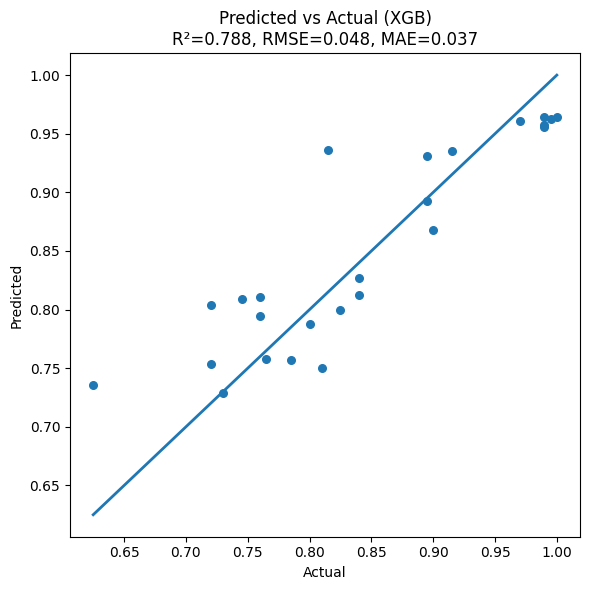

Saved: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna\pred_vs_actual_optuna.png


In [62]:
best_params = study.best_params.copy()
best_params.update({
    "random_state": RANDOM_SEED,
    "tree_method": "hist",
    "n_jobs": max(1, os.cpu_count()-1),
    "eval_metric": "rmse",
})
best_model = XGBRegressor(**best_params)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED
)

best_model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

pred = best_model.predict(X_test)
r2   = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
mae  = mean_absolute_error(y_test, pred)
print(f"Test -> R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, s=30)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx], lw=2)
plt.title(f"Predicted vs Actual (XGB)\nR²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout()
out_path = os.path.join(OUTDIR, "pred_vs_actual_optuna.png")
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)


In [1]:
# ===== 1) 用最优参数训练老师模型（可用全数据或训练集） =====
best_params = study.best_params.copy()
best_params.setdefault("tree_method", "hist")
best_params.setdefault("random_state", RANDOM_SEED)

# X_all / y_all：建议用你训练时的同一份数据（或全量）来导出公式
# 如果你上面已经有 X_train, y_train，也可以先拼回 DataFrame/ndarray 全量:
# X_all, y_all = X, y  # 若你手里保留了完整 X, y
X_all, y_all = X_train, y_train  # 若你打算用训练折来导出公式

xgb_teacher = XGBRegressor(**best_params)
xgb_teacher.fit(X_all, y_all)

# ===== 2) 标准化特征（保存均值/方差，便于部署复现） =====
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xz = scaler.fit_transform(X_all)

# ===== 3) 线性蒸馏（把老师的预测作为回归目标），得到“公式” =====
from sklearn.linear_model import LinearRegression
teacher_pred = xgb_teacher.predict(X_all)

lin = LinearRegression().fit(Xz, teacher_pred)
NEW_INTERCEPT = float(lin.intercept_)
Z_COEFFS = dict(zip(FEATURES, map(float, lin.coef_)))

print("NEW_INTERCEPT =", NEW_INTERCEPT)
print("Z_COEFFS =", Z_COEFFS)

# ===== 4) （可选）导出“复杂度 = 1 - success_rate”的线性公式 =====
COMPLEXITY_INTERCEPT = 1.0 - NEW_INTERCEPT
COMPLEXITY_COEFFS = {k: -v for k, v in Z_COEFFS.items()}

print("COMPLEXITY_INTERCEPT =", COMPLEXITY_INTERCEPT)
print("COMPLEXITY_COEFFS =", COMPLEXITY_COEFFS)

# ===== 5) 保存到 JSON，连同 scaler 一起存（强烈建议）=====
import json, os
payload = {
    "target": TARGET,                # 比如 "success_rate"
    "new_intercept": NEW_INTERCEPT,  # 线性蒸馏的截距
    "z_coeffs": Z_COEFFS,            # 标准化系数字典
    "complexity_intercept": COMPLEXITY_INTERCEPT,
    "complexity_coeffs": COMPLEXITY_COEFFS,
    "scaler": {                      # 用于推理时复现 z 分数
        "feature_order": FEATURES,
        "means": scaler.mean_.tolist(),
        "stds": scaler.scale_.tolist()
    },
    "xgb_best_params": best_params   # 记录老师超参
}
os.makedirs(OUTDIR, exist_ok=True)
with open(os.path.join(OUTDIR, "linear_formula_from_xgb.json"), "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2, ensure_ascii=False)
print("Saved ->", os.path.join(OUTDIR, "linear_formula_from_xgb.json"))


NameError: name 'study' is not defined